In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [17]:
# Load the dataset
X, y = fetch_california_housing(return_X_y=True)
feature_names = fetch_california_housing().feature_names

In [18]:
# Split it up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Regressor

In [14]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_sample_split=2):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])
    
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or num_samples < self.min_sample_split:
            return np.mean(y)
        
        best_feat, best_thresh = self._best_split(X, y)
        if best_feat is None:
            return np.mean(y)
        
        left_mask = X[:, best_feat] <= best_thresh
        right_mask = X[:, best_feat] > best_thresh

        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': best_feat, 'threshold': best_thresh, 'left': left, 'right': right}
    
    def _best_split(self, X, y):
        best_mse = float('inf')
        best_feat, best_thresh = None, None

        for feat in range(X.shape[1]):
            thresholds = np.unique(X[:, feat])
            for t in thresholds:
                left_mask = X[:, feat] <= t
                right_mask = X[:, feat] > t

                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue

                mse = self._calculate_mse(y[left_mask], y[right_mask])
                if mse < best_mse:
                    best_mse = mse
                    best_feat = feat
                    best_thresh = t

        return best_feat, best_thresh
    
    def _calculate_mse(self, left_y, right_y):
        left_mse = np.var(left_y) * len(left_y)
        right_mse = np.var(right_y) * len(right_y)
        return (left_mse + right_mse) / (len(left_y) + len(right_y))
    
    def _predict_sample(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
        

        

In [21]:
import numpy as np
from collections import Counter
from copy import deepcopy

class RandomForestRegressorFromScratch:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.feature_subsets = []

    def _get_feature_indices(self, n_features):
        if self.max_features == 'sqrt':
            return np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
        elif isinstance(self.max_features, int):
            return np.random.choice(n_features, self.max_features, replace=False)
        else:
            return np.arange(n_features)

    def fit(self, X, y):
        self.trees = []
        self.feature_subsets = []

        for _ in range(self.n_estimators):
            # Bootstrap sample
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # Feature subset
            feature_idx = self._get_feature_indices(X.shape[1])
            self.feature_subsets.append(feature_idx)

            # Train tree
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_sample_split=self.min_samples_split
            )
            tree.fit(X_sample[:, feature_idx], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([
            tree.predict(X[:, feat_idx]) for tree, feat_idx in zip(self.trees, self.feature_subsets)
        ])
        return np.mean(preds, axis=0)

    def feature_importances_(self, feature_names):
        # Count how often features were used across trees
        importances = Counter()
        total_splits = 0

        for tree, feat_idx in zip(self.trees, self.feature_subsets):
            stack = [tree.tree]
            while stack:
                node = stack.pop()
                if isinstance(node, dict):
                    importances[feature_names[feat_idx[node['feature']]]] += 1
                    total_splits += 1
                    stack.extend([node['left'], node['right']])

        # Normalize
        return {feat: count / total_splits for feat, count in importances.items()}



In [22]:
forest = RandomForestRegressorFromScratch(
    n_estimators=10,
    max_depth=6,
    max_features='sqrt'
)
forest.fit(X_train, y_train)

In [23]:
preds = forest.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.7713643429344356


In [34]:
importances = forest.feature_importances_(feature_names)
features_list = []
print("Feature Importances:")
for feat, score in sorted(importances.items(), key=lambda x: -x[1]):
    print(f"{feat}: {score:.3f}")
    features_list.append({'feature': feat, 'importance': score})

Feature Importances:
AveOccup: 0.209
Population: 0.202
Latitude: 0.187
AveRooms: 0.123
MedInc: 0.090
AveBedrms: 0.090
Longitude: 0.078
HouseAge: 0.022


In [35]:
feature_importance_ds = pd.DataFrame(features_list)
feature_importance_ds

,feature,importance
0,AveOccup,0.208981
1,Population,0.202073
2,Latitude,0.186528
3,AveRooms,0.122625
4,MedInc,0.089810
5,AveBedrms,0.089810
6,Longitude,0.077720
7,HouseAge,0.022453


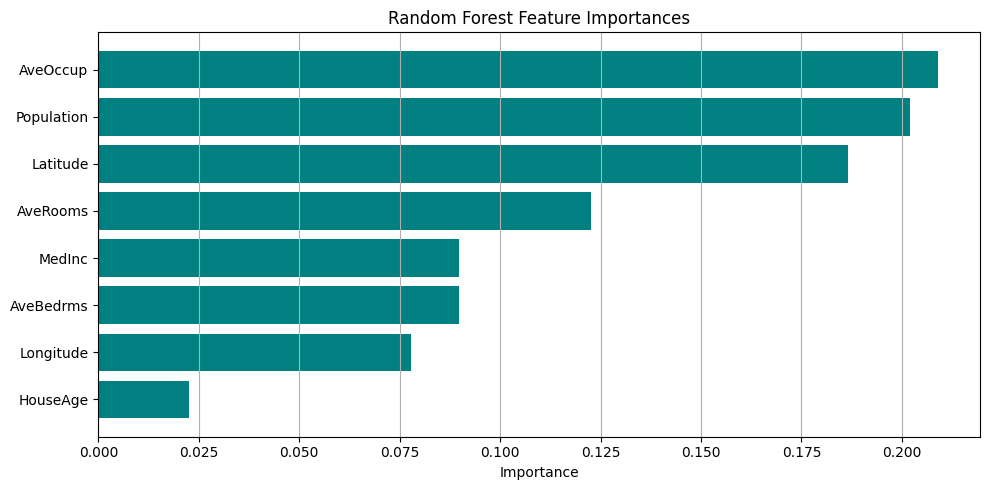

In [36]:
# feature_importance_df = pd.DataFrame({
#     'AveOccup': importances['AveOccup'],
# })

#Plot feature importances
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_ds['feature'], feature_importance_ds['importance'], color='teal')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()